In [ ]:
!pip install BaselineRemoval

In [ ]:
from BaselineRemoval import BaselineRemoval
import numpy as np
import pandas as pd

def read_file(path):
    file=pd.read_excel(path,header=None)
    data=file.values
    DATA=[]

    for d in data:
        baseObj=BaselineRemoval(d)
        data_p=baseObj.ZhangFit()
        DATA.append(data_p)

    DATABASE=np.array(DATA)

    DATA_N=DATABASE-np.mean(DATABASE)/np.std(DATABASE)
    DATA_N=np.expand_dims(DATA_N,2)
    return DATA_N

def window(Data,ppm):
    idx = np.where(ppm < 5)[0]
    ppm1=ppm[idx]
    idx2 = np.where(ppm1 > 0.49)[0]
    ppm2=ppm[idx2]
    data=Data[:,idx2]
    return data, ppm2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.layers import Bidirectional, LSTM
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
#from functions_read_files import read_file, window


SCSA_path = "/content/drive/MyDrive/Lipid Peak/DATA2000/SCSA.xlsx"
MRS_C_path = "/content/drive/MyDrive/Lipid Peak/DATA2000/MRS_C.xlsx"
ppm_path="/content/drive/MyDrive/Lipid Peak/DATA2000/ppm.xlsx"

In [ ]:
import pickle

file = open('/content/drive/MyDrive/Lipid Peak/Real Data/Augmented_MRS_Clean.pckl','rb')
Augmented_MRS_Clean = pickle.load(file)
file.close()

file = open('/content/drive/MyDrive/Lipid Peak/Real Data/Augmented_MRS.pckl','rb')
Augmented_MRS = pickle.load(file)
file.close()



In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.reset_states()

def BiLSTM_model():
    print('---Creating BiLSTM model---')
    model = Sequential()
    model.add(Bidirectional(LSTM(256,return_sequences=True),input_shape=(203,1)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Bidirectional(LSTM(256,input_shape=(203,1))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(203, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.00042047358423570646),metrics=['mean_squared_error'])

    return model

x=read_file(SCSA_path)
y=read_file(MRS_C_path)

file=pd.read_excel(ppm_path)
ppm=file.values
ppm=np.array(ppm)

x_w, ppm2=window(x,ppm)
y_w, ppm2=window(y,ppm)


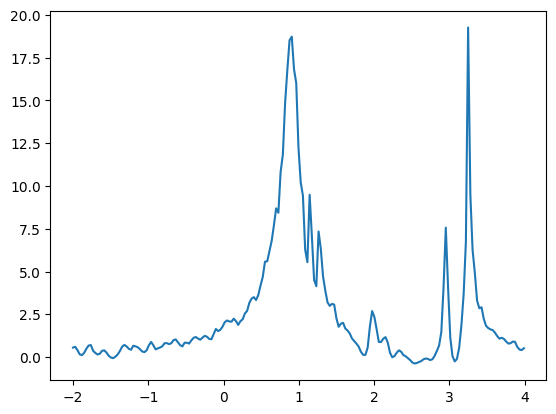

In [ ]:
plt.plot(ppm2,x_w[1,:,:])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_w, y_w, test_size=0.3, random_state=1)
model=BiLSTM_model()
history=model.fit(X_train, y_train, epochs=5000, batch_size=300, validation_split=0.3, callbacks=[CustomCallback()])


plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('BiLSTM_MSE_out.png')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('BiLSTM_loss_out.png')
plt.show()

model.evaluate(X_test, y_test, batch_size=100)

# Generate reconstructions
num_reconstructions = len(X_test)
samples = X_test
pures = y_test
reconstructions = model.predict(samples)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# Plot reconstructions
for i in np.arange(0, 3):
  # Get the sample and the reconstruction
  sample = np.array(samples[i])/np.amax(samples[i])
  pure = np.array(pures[i])/np.amax(pures[i])
  reconstruction = np.array(reconstructions[i])/np.amax(reconstructions[i])
  # Plot sample and reconstruciton
  axes[i].plot(ppm2,sample+2,label="SCSA output")
  axes[i].plot(ppm2,pure+1, label="Ground truth")
  axes[i].plot(ppm2,reconstruction,color='red',label="BiLSTM output")
  axes[i].set_xlabel('ppm')
  axes[i].legend()

